# Classification with Virtual Branching

In [1]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
import time
from sklearn.manifold import TSNE

In [29]:
from vbranch.callbacks import classification_acc
from vbranch.applications.fcn import SimpleFCNv1, SimpleFCNv2
from vbranch.applications.cnn import SimpleCNNSmall
from vbranch.losses import softmax_cross_entropy_with_logits

from vbranch.utils import TFSessionGrow, restore_sess
from vbranch.utils.training import get_data, bag_samples, get_data_iterator

In [3]:
SAVE = False
MODEL_ID = 1
ARCHITECTURE = 'fcn2'
DATASET = 'mnist'
NUM_CLASSES = 10
NUM_FEATURES = 784
SAMPLES_PER_CLASS = 100
BAGGING_SAMPLES = 1.

NUM_BRANCHES = 2
SHARED_FRAC = 0.25
BATCH_SIZE = 32
EPOCHS = 10
STEPS_PER_EPOCH = 100

## Data

In [4]:
(X_train, y_train), (X_test, y_test) = get_data(DATASET, ARCHITECTURE, NUM_CLASSES,
                                                NUM_FEATURES, SAMPLES_PER_CLASS)
print('Training set:', X_train.shape, y_train.shape)
print('Testing set:', X_test.shape, y_test.shape)

x_shape = (None,) + X_train.shape[1:]
y_shape = (None, NUM_CLASSES)

Training set: (60000, 784) (60000, 10)
Testing set: (10000, 784) (10000, 10)


We optionally perform bootstrap aggregation (bagging) by randomly sampling a random fraction of the original dataset. In general, bagging improves ensemble performance in addition to the gains from vanilla model averaging. A value of 0.6 works well for this task.

<br>
See original paper on bagging:

https://www.stat.berkeley.edu/~breiman/bagging.pdf

In [5]:
# Bagging
if BAGGING_SAMPLES < 1:
    x_train_list, y_train_list = bag_samples(X_train, y_train, NUM_BRANCHES, 
                                             max_samples=BAGGING_SAMPLES)

    for i, (x_, y_) in enumerate(zip(x_train_list, y_train_list)):
        print('Bag {}:'.format(i+1), x_.shape, y_.shape)

## Train

We use the TF Dataset API to train our models. Calling `get_data_iterator` returns the input tensor(s) and initializers for the training and testing data iterators. Each iterator will return random batches from the same data or different data (in the case of bagging). The initializers must be fed to the model compiler and will be called internalling during fitting.

In [6]:
# Note models from experiments will be saved in separate format
if not os.path.isdir('models'):
    os.system('mkdir models')

if NUM_BRANCHES == 1:
    model_name = '{}-{}_{:d}'.format(DATASET, ARCHITECTURE, MODEL_ID)
else:
    model_name = 'vb-{}-{}-B{:d}-S{:.2f}_{:d}'.format(DATASET, ARCHITECTURE,
                                                      NUM_BRANCHES, SHARED_FRAC, MODEL_ID)
model_path = os.path.join('models', model_name)
print('Model path:', model_path)

Model path: models/vb-mnist-fcn2-B2-S0.25_1


In [7]:
tf.reset_default_graph()

inputs, labels, train_init_op, test_init_op = get_data_iterator(x_shape, y_shape, batch_size=BATCH_SIZE, 
                                                                n=NUM_BRANCHES, share_xy=BAGGING_SAMPLES == 1)

if NUM_BRANCHES > 1:
    for i, (ip_, label_) in enumerate(zip(inputs, labels)):
        print('Branch {}'.format(i+1))
        print('Input:', ip_)
        print('Label:', label_)
else:
    print('Single input (no branching)')
    print('Input:' , inputs)
    print('Label:', labels)

Instructions for updating:
Colocations handled automatically by placer.
Branch 1
Input: Tensor("input:0", shape=(?, 784), dtype=float32)
Label: Tensor("input:1", shape=(?, 10), dtype=float32)
Branch 2
Input: Tensor("input_1:0", shape=(?, 784), dtype=float32)
Label: Tensor("input_1:1", shape=(?, 10), dtype=float32)


`Model` and `ModelVB` instances can be created using the function (defined in `vbranch.applications`). We declare the model under a `tf.variable_scope` in order to more easily retreive model parameters later on and enable parameter sharing between branches. Callbacks are used to calculate accuracy and other metrics during training.

In [8]:
name = 'model'

with tf.variable_scope(name, reuse=tf.AUTO_REUSE):
    if ARCHITECTURE == 'fcn':
        model = SimpleFCNv1(inputs, NUM_CLASSES, name=name, shared_frac=SHARED_FRAC)
    elif ARCHITECTURE == 'fcn2':
        model = SimpleFCNv2(inputs, NUM_CLASSES, name=name, shared_frac=SHARED_FRAC)
    elif ARCHITECTURE == 'cnn':
        model = SimpleCNNSmall(inputs, NUM_CLASSES, name=name, shared_frac=SHARED_FRAC)
    else:
        raise ValueError('invalid model')

    optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
    model.compile(optimizer, softmax_cross_entropy_with_logits(), 
                  train_init_op, test_init_op, labels=labels, 
                  callbacks={'acc':classification_acc(NUM_BRANCHES)})

Instructions for updating:
Use tf.cast instead.


In [9]:
model.summary()

i  Layer name                Output shape           Num param  Inbound  
------------------------------------------------------------------------
   Input                     [None,784]                                 
------------------------------------------------------------------------
   Input                     [None,784]                                 
------------------------------------------------------------------------
0  fc1 (Dense)               [None,128] [None,384]  703360     input    
                             [None,128] [None,384]                      
------------------------------------------------------------------------
1  bn1 (BatchNormalization)  [None,128] [None,384]  1792       fc1      
                             [None,128] [None,384]                      
------------------------------------------------------------------------
2  relu1 (Activation)        [None,128] [None,384]  0          bn1      
                             [None,128] [None,384] 

In [15]:
if NUM_BRANCHES > 1:
    print(model.losses)

{'loss_2': <tf.Tensor 'model/loss_2:0' shape=() dtype=float32>, 'loss_1': <tf.Tensor 'model/loss_1:0' shape=() dtype=float32>}


In order to train the model, we must supply the training and validation data. The training data can either be shared or different (in the case of bagging). Either way, the batches are random so each branch gets "different" data. Finally, we call the `fit` method, which handles both `Model` and `ModelVB` and returns a dictionary of all metrics over epochs. 

In [16]:
if NUM_BRANCHES == 1 or BAGGING_SAMPLES == 1:
    train_dict = {'x:0': X_train, 'y:0': y_train, 'batch_size:0': BATCH_SIZE}
else:
    train_dict = {}
    for i in range(NUM_BRANCHES):
        train_dict['vb{}_x:0'.format(i+1)] = x_train_list[i]
        train_dict['vb{}_y:0'.format(i+1)] = y_train_list[i]
    train_dict['batch_size:0'] = BATCH_SIZE
    
val_dict = {'x:0': X_test, 'y:0': y_test, 'batch_size:0': len(X_test)}

In [17]:
history = model.fit(EPOCHS, STEPS_PER_EPOCH, train_dict=train_dict,
                    val_dict=val_dict, log_path=model_path if SAVE else None)

Epoch 1/10
 - 5s - loss_2: 0.4884 - loss_1: 0.4945 - acc_2: 0.9174 - acc_1: 0.9091 - acc_ensemble: 0.9255 - val_loss_2: 0.2701 - val_loss_1: 0.2872 - val_acc_2: 0.9170 - val_acc_1: 0.9087 - val_acc_ensemble: 0.9261
Epoch 2/10
 - 3s - loss_2: 0.1651 - loss_1: 0.1860 - acc_2: 0.9278 - acc_1: 0.9304 - acc_ensemble: 0.9404 - val_loss_2: 0.2315 - val_loss_1: 0.2267 - val_acc_2: 0.9272 - val_acc_1: 0.9276 - val_acc_ensemble: 0.9377
Epoch 3/10
 - 4s - loss_2: 0.1450 - loss_1: 0.1130 - acc_2: 0.9399 - acc_1: 0.9389 - acc_ensemble: 0.9457 - val_loss_2: 0.1922 - val_loss_1: 0.1942 - val_acc_2: 0.9395 - val_acc_1: 0.9395 - val_acc_ensemble: 0.9471
Epoch 4/10
 - 4s - loss_2: 0.0705 - loss_1: 0.1000 - acc_2: 0.9441 - acc_1: 0.9429 - acc_ensemble: 0.9487 - val_loss_2: 0.1927 - val_loss_1: 0.1940 - val_acc_2: 0.9383 - val_acc_1: 0.9386 - val_acc_ensemble: 0.9444
Epoch 5/10
 - 4s - loss_2: 0.0549 - loss_1: 0.0532 - acc_2: 0.9459 - acc_1: 0.9473 - acc_ensemble: 0.9518 - val_loss_2: 0.1842 - val_loss_1:

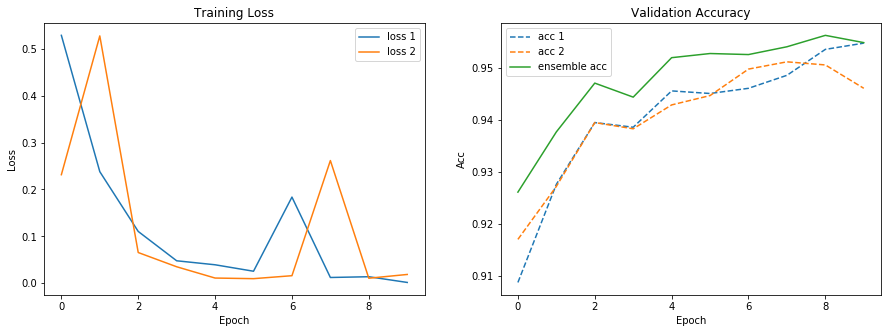

In [27]:
plt.figure(figsize=(15, 5))

plt.subplot(1,2,1)
for i in range(NUM_BRANCHES):
    plt.plot(history['loss_{}'.format(i+1)], label='loss {}'.format(i+1))
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
for i in range(NUM_BRANCHES):
    plt.plot(history['val_acc_{}'.format(i+1)], linestyle='--', label='acc {}'.format(i+1))
plt.plot(history['val_acc_ensemble'], label='ensemble acc')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.legend()

plt.show()

The ensemble never has validation accuracy greater than the individual branches. In fact, the ensemble accuracy exceeds the individual accuracies by a large margin for most epochs. Of course, this is only a limited example. See below for more comprehensive results.

## Evaluation

Run the following script in the terminal. This script with perform multiple trials of the code above and with varying hyperparameters. Individual configurations can also be called from the terminal using the following scripts (arguments shown).

In [32]:
from vbranch.utils.generic import get_model_path, get_vb_model_path
from vbranch.utils.test import baseline_classification

### Baseline

In [37]:
# List of models to run
model_id_list = range(1, 9)
baseline_acc_list = []

for model_id in model_id_list:
    tf.reset_default_graph()
    model_path = get_model_path(DATASET, ARCHITECTURE, model_id=model_id)
    
    with TFSessionGrow() as sess:
        restore_sess(sess, model_path)
        acc = baseline_classification(sess, X_test, y_test)['acc']
        print('Model {}:'.format(model_id), acc)
        baseline_acc_list.append(acc)
        
print('MEAN:', np.mean(baseline_acc_list))
print('STD:', np.std(baseline_acc_list))

INFO:tensorflow:Restoring parameters from models/mnist-fcn2/model_1/ckpt
Model 1: 0.9494
INFO:tensorflow:Restoring parameters from models/mnist-fcn2/model_2/ckpt
Model 2: 0.9432
INFO:tensorflow:Restoring parameters from models/mnist-fcn2/model_3/ckpt
Model 3: 0.9483
INFO:tensorflow:Restoring parameters from models/mnist-fcn2/model_4/ckpt
Model 4: 0.9466
INFO:tensorflow:Restoring parameters from models/mnist-fcn2/model_5/ckpt
Model 5: 0.9445
INFO:tensorflow:Restoring parameters from models/mnist-fcn2/model_6/ckpt
Model 6: 0.9468
INFO:tensorflow:Restoring parameters from models/mnist-fcn2/model_7/ckpt
Model 7: 0.9378
INFO:tensorflow:Restoring parameters from models/mnist-fcn2/model_8/ckpt
Model 8: 0.9527
MEAN: 0.9461625
STD: 0.004181196


### Ensemble

In [ ]:
test_outputs = []
test_losses = []
test_accs = []

num_models = 4
graphs = [tf.Graph() for _ in range(5)]
sessions = [tf.Session(graph=g) for g in graphs]

for i in np.random.choice(5, num_models, replace=False):
    with graphs[i].as_default():
        model_path = 'models/mnist-{}_{}'.format(architecture, i + 1)
        meta_path = os.path.join(model_path, 'ckpt.meta')
        ckpt = tf.train.get_checkpoint_state(model_path)
        
        imported_graph = tf.train.import_meta_graph(meta_path)
        imported_graph.restore(sessions[i], ckpt.model_checkpoint_path)
                
        sessions[i].run('test_init_op', feed_dict={'batch_size:0': len(X_test)})
        
        output, loss, acc = sessions[i].run(['model_%d'%(i+1)+'/'+'output:0', 
                                             'loss:0', 'acc:0'])
        test_outputs.append(output)
        test_losses.append(loss)
        test_accs.append(acc)

### Virtual Branching

In [ ]:
model_id_list = [1]
vbranch_acc_list = []

for model_id in model_id_list:
    tf.reset_default_graph()
    model_name = 'vb-{}-{}-B{:d}-S{:.2f}_{:d}'.format(DATASET, ARCHITECTURE,
                                            NUM_BRANCHES, SHARED_FRAC, model_id)
    model_path = os.path.join('models', model_name)
    
    with TFSessionGrow() as sess:
        restore_sess(sess, model_path)
        acc, branch_acc = vbranch_classification(sess, X_test, y_test, 
                                     model_name='model_'+str(model_id)+'_1', 
                                     num_classes=NUM_CLASSES, 
                                     n_branches=NUM_BRANCHES)
        print('Model {} acc:'.format(model_id), acc, branch_acc)
        vbranch_acc_list.append(acc)
        
print('Mean acc:', np.mean(vbranch_acc_list), ', std:', np.std(vbranch_acc_list))

### Feature Visualization

In [ ]:
def get_tsne(features):
    start = time.time()
    tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
    tsne_results = tsne.fit_transform(features)

    print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-start))
    return tsne_results

In [ ]:
X_sample, y_sample = bag_samples(X_train, y_train, 1, max_samples=250)
print(X_sample.shape, y_sample.shape)

In [ ]:
tf.reset_default_graph()
model_name = '{}-{}_{:d}'.format(DATASET, ARCHITECTURE, MODEL_ID)
model_path = os.path.join('models', model_name)

with TFSessionGrow() as sess:
    restore_sess(sess, model_path)
    baseline_features = sess.run('model_{}_1/output/output:0'.format(MODEL_ID), 
                                 feed_dict={'x_test:0':X_sample})

In [ ]:
tf.reset_default_graph()
model_name = 'vb-{}-{}-B{:d}-S{:.2f}_{:d}'.format(DATASET, ARCHITECTURE,
                                            NUM_BRANCHES, SHARED_FRAC, MODEL_ID)
model_path = os.path.join('models', model_name)
    
with TFSessionGrow() as sess:
    restore_sess(sess, model_path)
    
    outputs = []
    for i in range(NUM_BRANCHES):
        name = os.path.join('model_{}_1/output/vb{}/output:0'.format(MODEL_ID, i+1))
        outputs.append(name)
        
    vbranch_features = sess.run(outputs, feed_dict={'x_test:0':X_sample})
    mean_vbranch_features = np.mean(vbranch_features, axis=0)

In [ ]:
baseline_tsne = get_tsne(baseline_features)
vbranch_tsne = get_tsne(mean_vbranch_features)
sample_labels = np.argmax(y_sample, axis=-1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.scatter(baseline_tsne[:,0], baseline_tsne[:,1], c=sample_labels, cmap=plt.cm.jet)
plt.colorbar()
plt.title('Baseline')

plt.subplot(1, 2, 2)
plt.scatter(vbranch_tsne[:,0], vbranch_tsne[:,1], c=sample_labels, cmap=plt.cm.jet)
plt.colorbar()
plt.title('Virtual Branching')

plt.show()

### Correlation and Strength

In [ ]:
from vbranch.utils.generic_utils import get_model_path, get_vb_model_path
from vbranch.utils.test_utils import compute_correlation_strength, compute_acc_from_logits

In [ ]:
y_labels = np.argmax(y_test, axis=-1)

model_id_list = range(1, 9)
output_list = []
acc_list = []
pred_list = []

for model_id in model_id_list:
    tf.reset_default_graph()

    with tf.Session() as sess:
        model_path = get_model_path(DATASET, ARCHITECTURE, NUM_CLASSES, 
                                    SAMPLES_PER_CLASS, model_id)
        restore_sess(sess, model_path)
        output = sess.run('model_{}_1/output:0'.format(model_id),
            feed_dict={'x_test:0':X_test})

    output_list.append(output)
    acc_list.append(compute_acc_from_logits(output, y_test, NUM_CLASSES))
    pred_list.append(np.argmax(output, axis=1))
    
model_preds = np.array(pred_list).transpose(1,0)
baseline_corr, baseline_strength = compute_correlation_strength(model_preds, y_labels, 
                                                                NUM_CLASSES, 
                                                                len(model_id_list))

print('Mean correlation:', baseline_corr)
print('Strength:' , baseline_strength)

In [ ]:
shared_frac_list = [0, 0.25, 0.5, 0.75, 1]
shared_correlation_list = []
shared_strength_list = []

for shared in shared_frac_list:
    mean_correlation_list = []
    strength_list = []
    
    for model_id in range(1, 5):
        model_path = get_vb_model_path(DATASET, ARCHITECTURE, NUM_BRANCHES, shared, 
                                       NUM_CLASSES, SAMPLES_PER_CLASS, model_id)

        tensors = []
        for i in range(NUM_BRANCHES):
            tensors.append('model/output/vb{}/output:0'.format(i+1))

        tf.reset_default_graph()

        with tf.Session() as sess:
            restore_sess(sess, model_path)
            feed_dict = feed_dict={'x_test:0': X_test, 'y_test:0': y_test}
            outputs, acc = sess.run([tensors, 'acc_ensemble_1:0'], feed_dict=feed_dict)
            
        preds = np.array([np.argmax(x, axis=1) for x in outputs]).transpose(1,0)
        mean_correlation, strength = compute_correlation_strength(preds, y_labels, NUM_CLASSES, NUM_BRANCHES)
        
        mean_correlation_list.append(mean_correlation)
        strength_list.append(strength)
        
    shared_correlation_list.append([np.mean(mean_correlation_list), np.std(mean_correlation_list)])
    shared_strength_list.append([np.mean(strength_list), np.std(strength_list)])

In [ ]:
plt.plot(shared_frac_list, np.array(shared_correlation_list)[:, 0], label='correlation')
plt.plot(shared_frac_list, np.array(shared_strength_list)[:, 0], label='strength')

# Baseline
plt.plot(shared_frac_list, [baseline_corr]* len(shared_correlation_list), 
         label='baseline correlation', linestyle='--')
plt.plot(shared_frac_list, [baseline_strength]* len(shared_correlation_list), 
         label='baseline strength', linestyle='--')

plt.xlabel('shared frac')
plt.title('Correlation and Strength')
plt.legend()

plt.savefig('figs/correlation-strength.png')
plt.show()